# Solving the MECP with QAOA+ using "Random Parameters" technique 

## Import Modules & Define Functions

In [6]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *

In [7]:
from datetime import datetime
import math 
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [8]:
def write_params_on_file(DATA_FILE, params):
    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choice of k (chosen_k): {params['chosen_k']}\n")

    
    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of k (chosen_k): {params['chosen_k']}")
    print(f"##########################################")

## Set Parameters

In [15]:
# Get parameters from the user
params = get_parameters_from_user()

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_k = params['chosen_k']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']
n = params['n']

Number of layers (p), default is 3: 1
Number of random attempts, default is 20: 2
String initialization (all1 or all0), default is 'all1': 
Size n (6, 8, 10), default is 6: 
Number or list of numbers from 1 to 10 for chosen instances, default is [1, ..., 10]: 1
Choice for 'chosen_k' ('L=max(L_EC)', 'L=n', 'L=L_MEC'), default is 'L=L_MEC': 


In [10]:
# This is computed in QAOA_k.ipynb
k_dict = {'L=L_MEC': [0.167,0.167,0.167,0.112,0.167,0.167,0.25,0.167,0.084,0.084],
         'L=max(L_EC)': [0.167,0.167,0.25,0.167,0.334,0.25,0.25,0.167,0.084,0.084],
         'L=n': [0.334, 0.5, 0.5, 0.334, 0.5, 0.5, 0.5, 0.334, 0.25, 0.25]}

## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



**************************************************
Instance 1 with h = 0.167



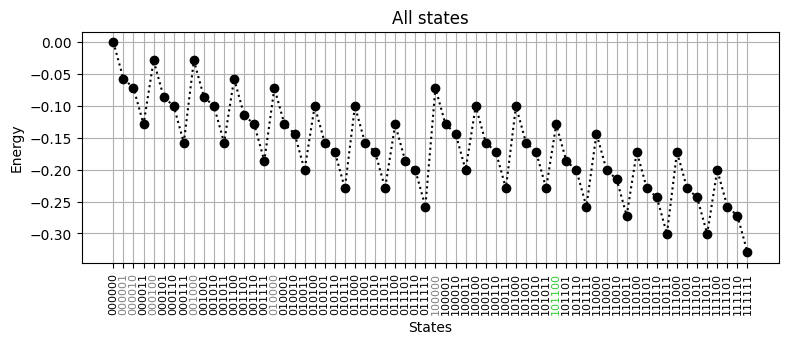

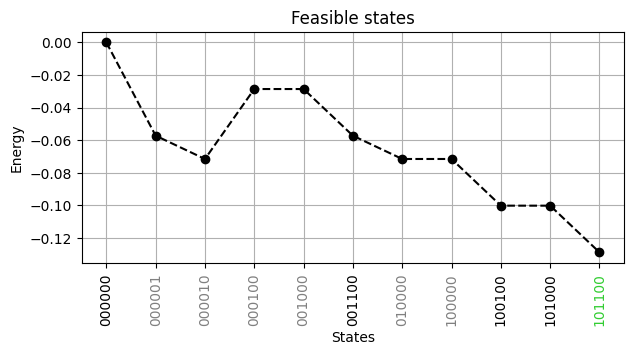

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 1
Number of random attempts: 2
Initialization type: all1
Size (n): 6
Chosen instances (chosen_instances): [1]
Choice of k (chosen_k): L=L_MEC
##########################################

---------- 1/2 random_attempts -----------

pars_0 = [2.8873870877336754, 1.301722881721247]
bnds = [(0, 6.283185307179586), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.087755
         Iterations: 85
         Function evaluations: 164
E_min = result.fun + constant = -0.0769453130571143
E_min = result.fun = 0.08775468694288571

Optimal parameters: betas, gammas = [4.556850464708434], [-2.8049921967078144e-05]
--> ***UPDATING THE BEST ATTEMPT***


---------- 2/2 random_attempts -----------

pars_0 = [5.225592930353677, -86.6739121475624]
bnds = [(0, 6.283185307179586), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.094263
         Iterations

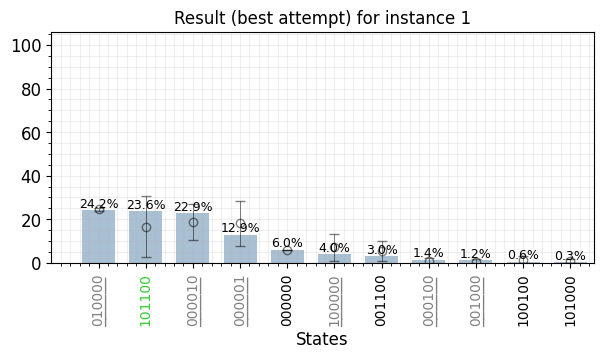

Result saved in:
random_parameters_2025-01-09@11h44m15s/dim6_mail1_all1_random_p1_2ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv
random_parameters_2025-01-09@11h44m15s/dim6_mail1_all1_random_p1_2ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]_data.txt

TOTAL ELAPSED TIME: 0.12461733818054199 minutes.


In [20]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for instance in chosen_instances:
    h = k_dict_new[chosen_k][instance-1]
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.

    
    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]
    
    
    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)

    
    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]
        
      
    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)    
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=False)
    
    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution
    
    
    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    

    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)
    
    
    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters
        
        E_best = 100
        TOTAL_start_time = time.time()
    
        for attempt in range(1,random_attempts+1):                           
            print(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            
            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost, 
                                mixer_operator=qc_mixing, 
                                initial_state=qc_initial, 
                                reps=p, name='QAOA+')

            
            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
        
            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()

            
            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************
            
            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]  
            bnds = [bnds_beta]*p + [bnds_gamma]*p
            
            print(f"pars_0 = {pars_0}")
            print(f"bnds = {bnds}\n")
            
            
            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds, 
                              args=(ansatz_isa, hamiltonian_isa, estimator), 
                              method="Nelder-Mead", 
                              options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)

            
            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration) 
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()
            
            
            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            print(f"E_min = result.fun + constant = {E_min}")
            print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")
            
            
            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')

            
            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
            else:
                print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")
        
                    
            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************
            
            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas 
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement
            
            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()
       
            
            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************
            
            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:]) 

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit
            
            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()
            
            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False) 
            
            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']
            
            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")    
    
        
    
        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)
        
        
        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts, 
                                      f'counts_p{p}_{best_attempt}of{random_attempts}', 
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")
        
        
        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

## (Optional) Draw the latest instance QAOA circuit

Instance #2


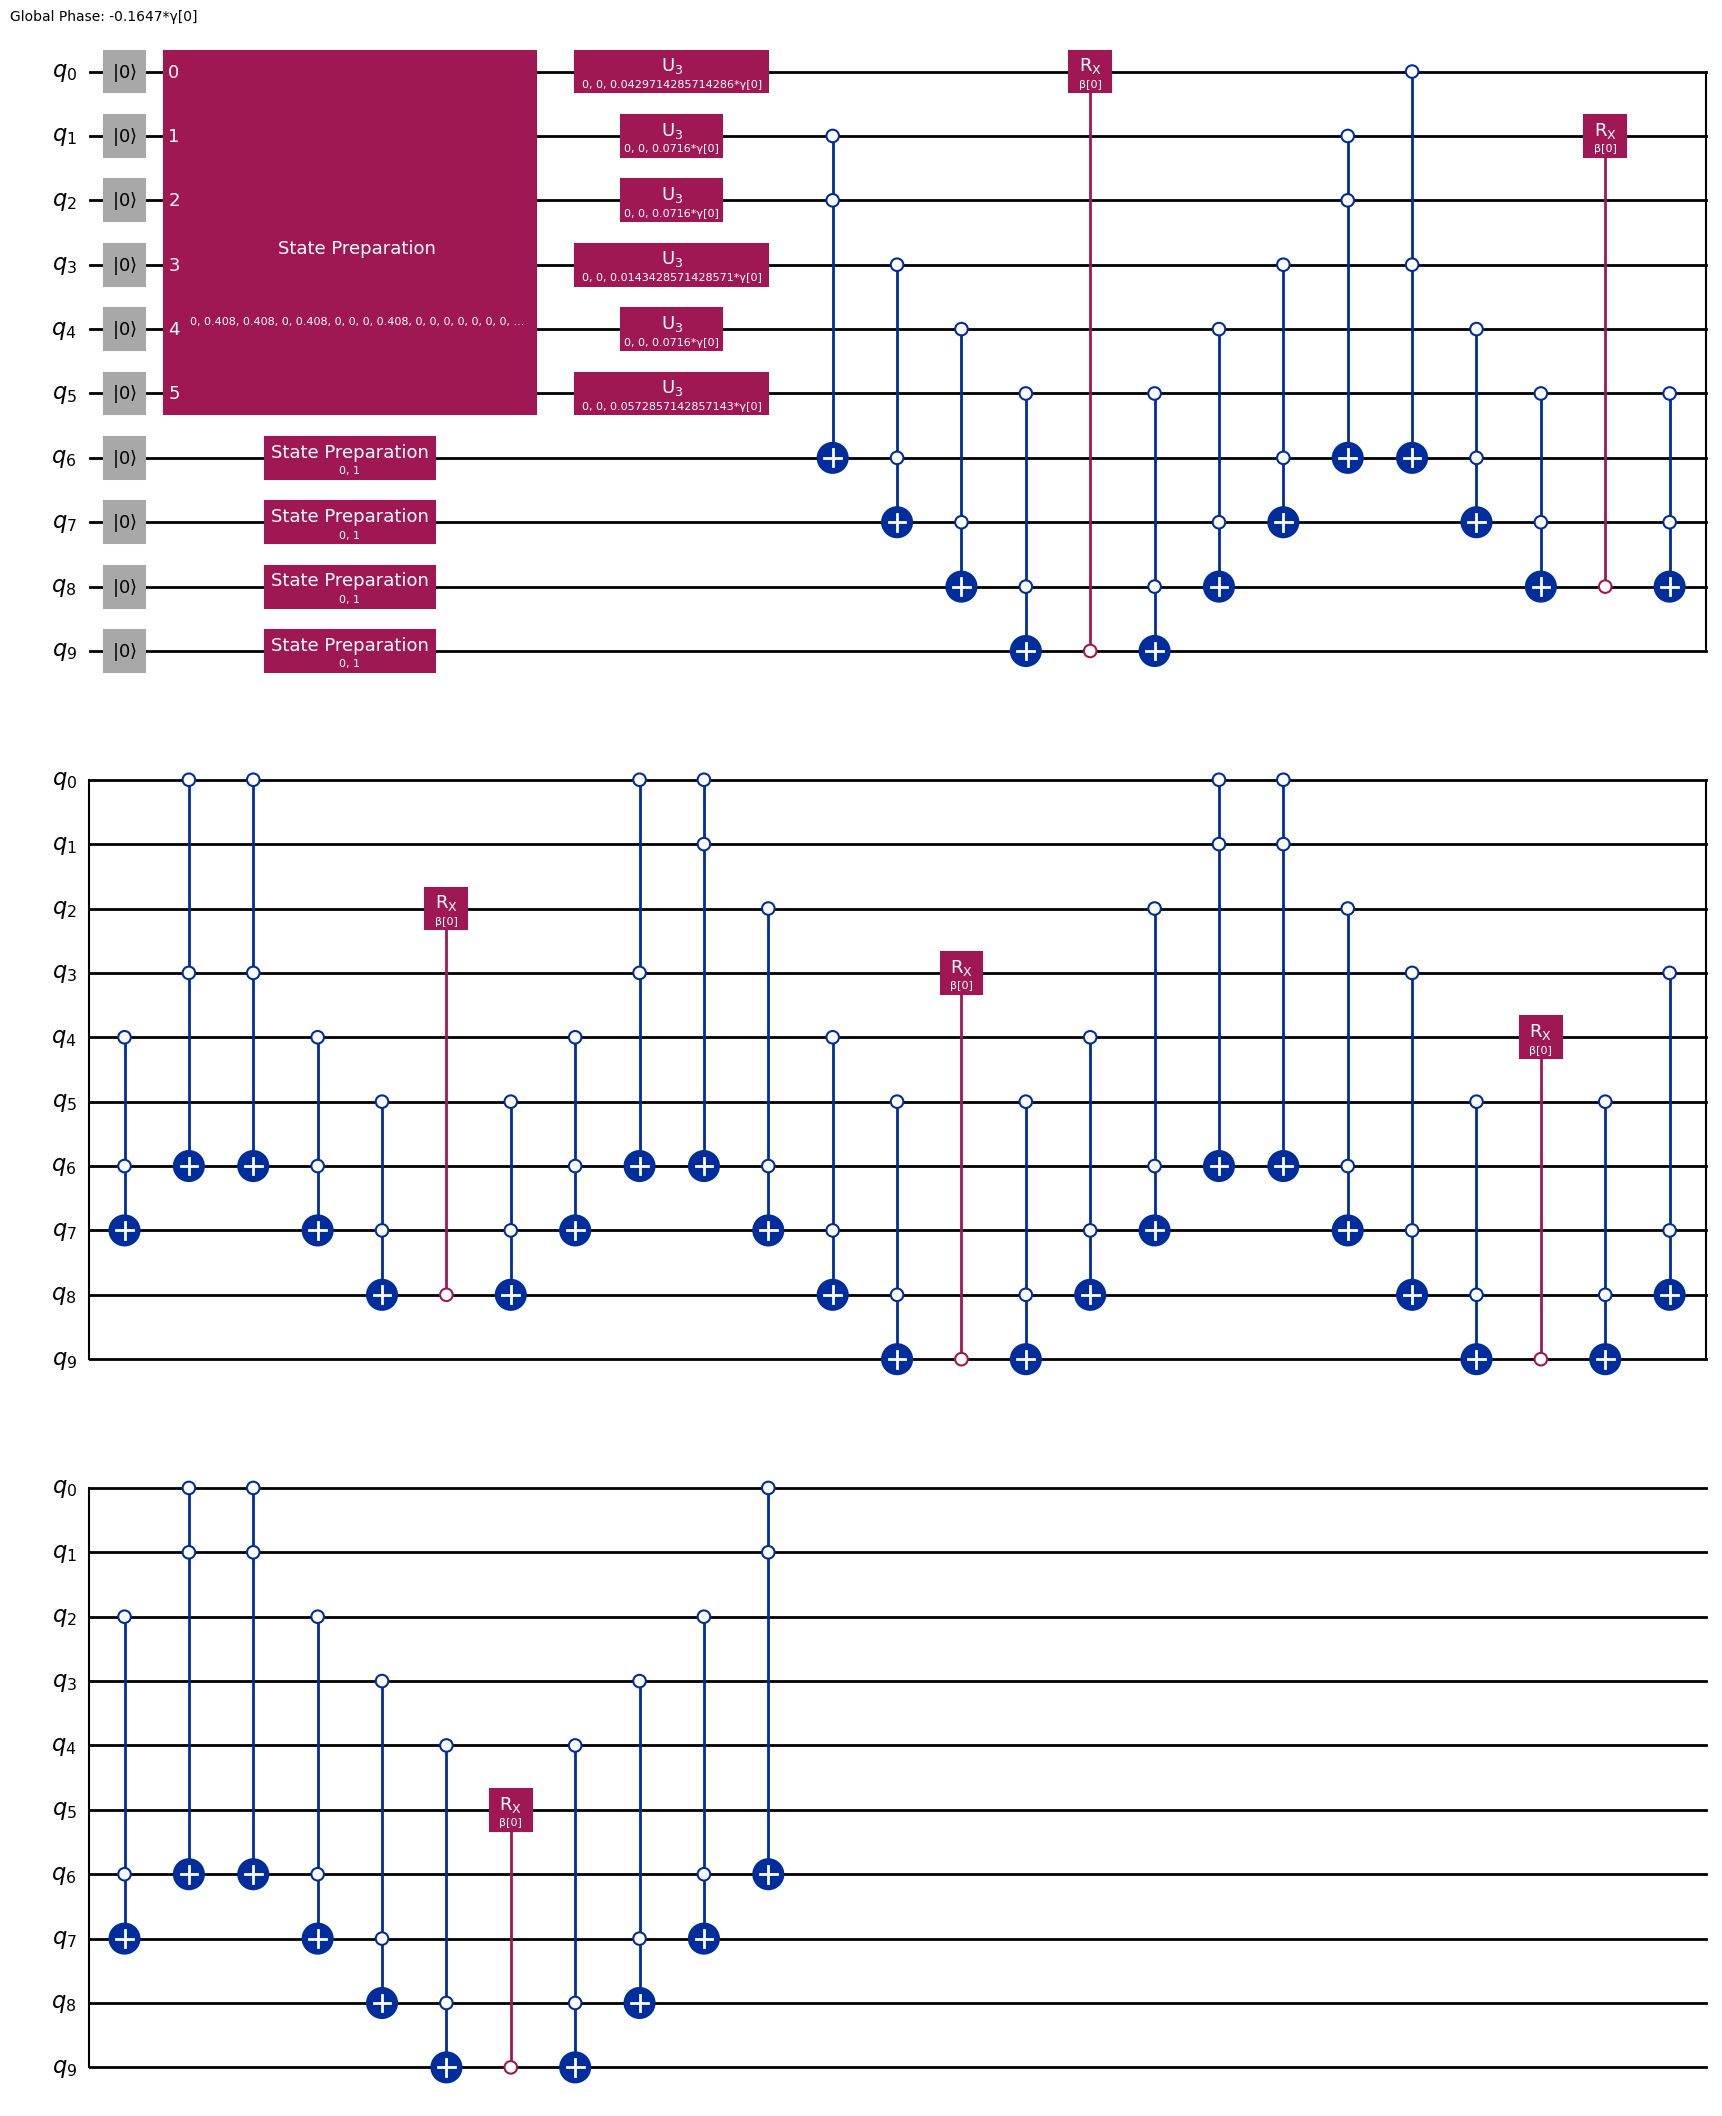

In [7]:
print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

## Read from File
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

./random_parameters_2025-01-09@11h10m26s/2025-01-09@11h10m26s_dim6_mail1_all1_random_p1_3ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]_data.txt
2
./random_parameters_2025-01-09@11h10m26s/2025-01-09@11h10m26s_dim6_mail2_all1_random_p1_3ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]_data.txt
2


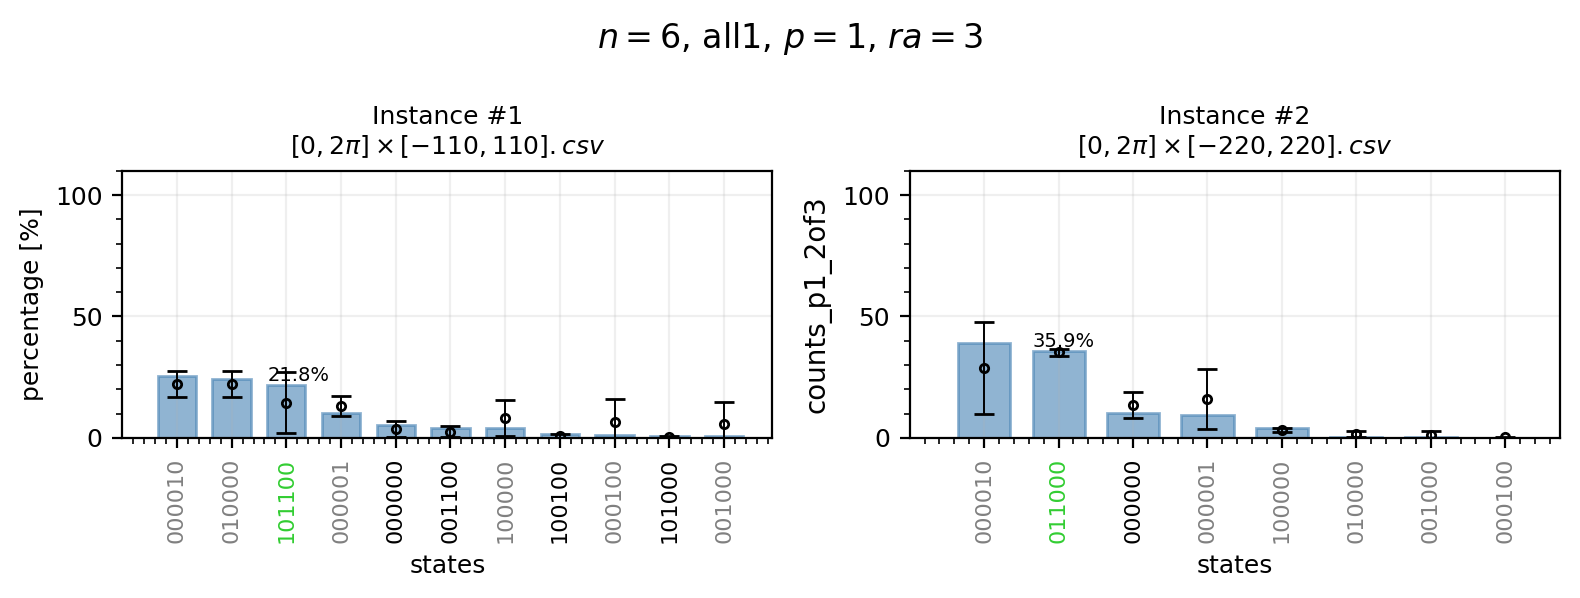

In [13]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-01-09@11h10m26s"

# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list, 
                       colorchosen="steelblue", alpha=0.6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"], 
                       dont_show_in_titles=["n", "p", "ra", "k", "init"], 
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0], 
              colorchosen='indigo', alpha=0.4,
              dont_show_in_title = [], 
              figsize=(10,4), dpi=200, N=10)